In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
import numpy as np

# Preprocessing Notebook

### Dataset loading

In [2]:
# Load data

y_data = {}
y_test_data = pd.read_csv(f"../data/test.csv")
X_test_estimated_data = {}
X_train_estimated_data = {}
X_train_observed_data = {}
locations = ["A", "B", "C"]

for location in locations:
    y_data[location] = pd.read_parquet(f"../data/{location}/train_targets.parquet")

    X_test_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_test_estimated.parquet"
    )
    X_train_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_estimated.parquet"
    )
    X_train_observed_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_observed.parquet"
    )

In [3]:
# Combine data

combine_data = (
    lambda data: pd.concat(data.values(), keys=data.keys())
    .reset_index()
    .drop(columns="level_1")
    .rename(columns={"level_0": "location"})
)

y = combine_data(y_data).sort_values(by=["time", "location"])

y_test_data = y_test_data.rename(columns={"prediction": "pv_measurement"})
y_test_data = y_test_data[["time", "location", "pv_measurement"]]

# Add Kaggle test data to y
y = pd.concat([y, y_test_data]).sort_values(by=["time", "location"])
y["time"] = pd.to_datetime(y["time"])

X_train_observed = combine_data(X_train_observed_data).assign(data_type="observed")
X_train_estimated = combine_data(X_train_estimated_data).assign(data_type="estimated")
X_test_estimated = combine_data(X_test_estimated_data).assign(data_type="test")

X = pd.concat([X_train_observed, X_train_estimated, X_test_estimated]).sort_values(
    by=["date_forecast", "location"]
)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (413791, 49)
y shape: (101248, 3)


### Data cleaning

#### Resample data to hourly granularity

In [29]:
# Custom aggregation function
def custom_resample(aggregation_dict): 
    result = {}
    for column in X.columns:
        if column in ["date_forecast"]:
            continue

        aggregation = aggregation_dict.get(column, 'mean')  # Use 'mean' by default

        result[column] = aggregation
    return result

# Specify the aggregation method for specific columns
aggregation_dict = {
    "location": "first",
    "data_type": "first",

    # Categorical weather features
    "is_day:idx": "first",
    "is_in_shadow:idx": "first",
    "precip_type_5min:idx": "first",
    "dew_or_rime:idx": "first",
    "snow_drift:idx": "first",
}

X = (
    X.set_index("date_forecast")
    .groupby("location")
    .resample("H")
    .apply(custom_resample(aggregation_dict))
    .drop(columns=["location"])
    .reset_index()
    .sort_values(by=["date_forecast", "location"])
    .reset_index(drop=True)
)

#### Remove NaN rows

In [30]:
# Find all rows that only contain NaN in X

nan_rows = X[X.drop(columns=["date_forecast", "location"]).isna().all(axis=1)].index

X = X.drop(nan_rows).reset_index(drop=True)
display(X.describe())

# Find all rows that only contain NaN in y

nan_rows = y[y.drop(columns=["time", "location"]).isna().all(axis=1)].index

y = y.drop(nan_rows).reset_index(drop=True)
display(y.describe())

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc
count,103450,103450.000000,103450.000000,85710.000000,1.034500e+05,103450.000000,95988.000000,103450.000000,103450.000000,103450.000000,...,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,15342
mean,2021-02-27 11:19:43.458675712,6.022738,1.255468,2826.042725,5.340843e+05,148.359695,1731.769531,0.002707,275.193359,40.794903,...,-0.686987,0.056886,279.437805,73.530861,33048.472656,3.016936,0.675693,0.668086,0.000042,2023-02-14 19:23:08.778255872
min,2019-01-01 00:00:00,0.500000,1.139000,27.600000,0.000000e+00,0.000000,27.299999,-1.000000,247.300003,0.000000,...,-49.979000,0.000000,257.899994,0.000000,130.600006,0.000000,-7.300000,-9.300000,-0.100000,2022-10-27 07:00:18
25%,2020-02-15 04:00:00,4.000000,1.230000,1027.425049,0.000000e+00,0.000000,586.375000,0.000000,270.600006,0.000000,...,-17.913750,0.000000,274.799988,51.400002,16174.074951,1.700000,-1.300000,-0.600000,0.000000,2022-12-20 08:01:43
50%,2021-02-08 08:30:00,5.400000,1.255000,1808.800049,9.071450e+03,0.000000,1147.800049,0.000000,275.000000,0.000000,...,-0.612000,0.000000,278.700012,94.800003,37354.300781,2.700000,0.300000,0.700000,0.000000,2023-02-12 08:00:04
75%,2022-02-02 13:00:00,7.900000,1.279000,3846.399902,8.375345e+05,232.500000,2064.424805,0.000000,280.600006,68.800003,...,16.219999,0.100000,284.100006,100.000000,48493.375000,4.000000,2.500000,1.900000,0.000000,2023-04-06 07:00:03
max,2023-07-03 23:00:00,18.900000,1.441000,12431.299805,3.006697e+06,835.299988,11688.900391,1.000000,295.100006,340.100006,...,49.917999,1.400000,303.299988,100.000000,76737.796875,15.200000,12.200000,9.000000,0.100000,2023-07-02 07:00:31
std,NaN,2.769660,0.037384,2556.637451,8.380974e+05,233.467758,1828.418701,0.254843,7.012615,61.805099,...,24.190546,0.111681,6.694117,35.041138,18173.378906,1.761333,2.780369,1.889841,0.006889,NaN


,time,pv_measurement
count,85278,85278.000000
mean,2021-03-28 03:20:35.882642944,308.376045
min,2018-12-31 23:00:00,0.000000
25%,2020-03-29 14:00:00,0.000000
50%,2021-03-04 18:30:00,0.000000
75%,2022-02-26 09:00:00,186.200000
max,2023-07-03 23:00:00,5733.420000
std,NaN,796.633439


#### Remove outliers

In [31]:
# Remove outliers

detection_data = X.drop(
    columns=["date_forecast", "location", "date_calc", "data_type"]
).fillna(0)

outlier_detector = IsolationForest(
    n_estimators=100, contamination=0.01, random_state=42
).fit(detection_data)

outlier_mask = outlier_detector.predict(detection_data) == 1

In [32]:
# Remove repeated values


def find_repeated_indexes(df, column_name, repeat_count=12, ignore_zeros=True) -> list:
    """
    Find and return the indexes of rows with a specified number of repeated values in a given column.

    Parameters:
    - df: DataFrame to search for repeated rows.
    - column_name: Name of the column to check for repeated values.
    - repeat_count: Number of repeated values required to consider a row as a match.

    Returns:
    - List of indexes for rows with the specified number of repeated values in the given column.
    """
    repeated_indexes = []
    temp_repeated_indexes = []
    current_value = None

    for index, row in df.iterrows():
        value = row[column_name]

        if value == 0 and ignore_zeros:
            continue

        if value == current_value:
            temp_repeated_indexes.append(index)
        else:
            current_value = value
            if len(temp_repeated_indexes) <= repeat_count:
                temp_repeated_indexes.clear()
            else:
                repeated_indexes.extend(
                    set(temp_repeated_indexes) - set(repeated_indexes)
                )
                temp_repeated_indexes.clear()

    return repeated_indexes


for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y[y.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=24,
        ignore_zeros=True,
    )

    y = y.drop(repeated_indexes).reset_index(drop=True)

    # Drop rows with repeated zeros over 4 days,
    # ignore dates after '2023-05-01 00:00:00' as they are test data

    repeated_indexes = find_repeated_indexes(
        y[(y.location == location) & (y.time <= "2023-05-01 00:00:00")].sort_values(
            by=["location", "time"]
        ),
        "pv_measurement",
        repeat_count=72,
        ignore_zeros=False,
    )

    y = y.drop(repeated_indexes).reset_index(drop=True)

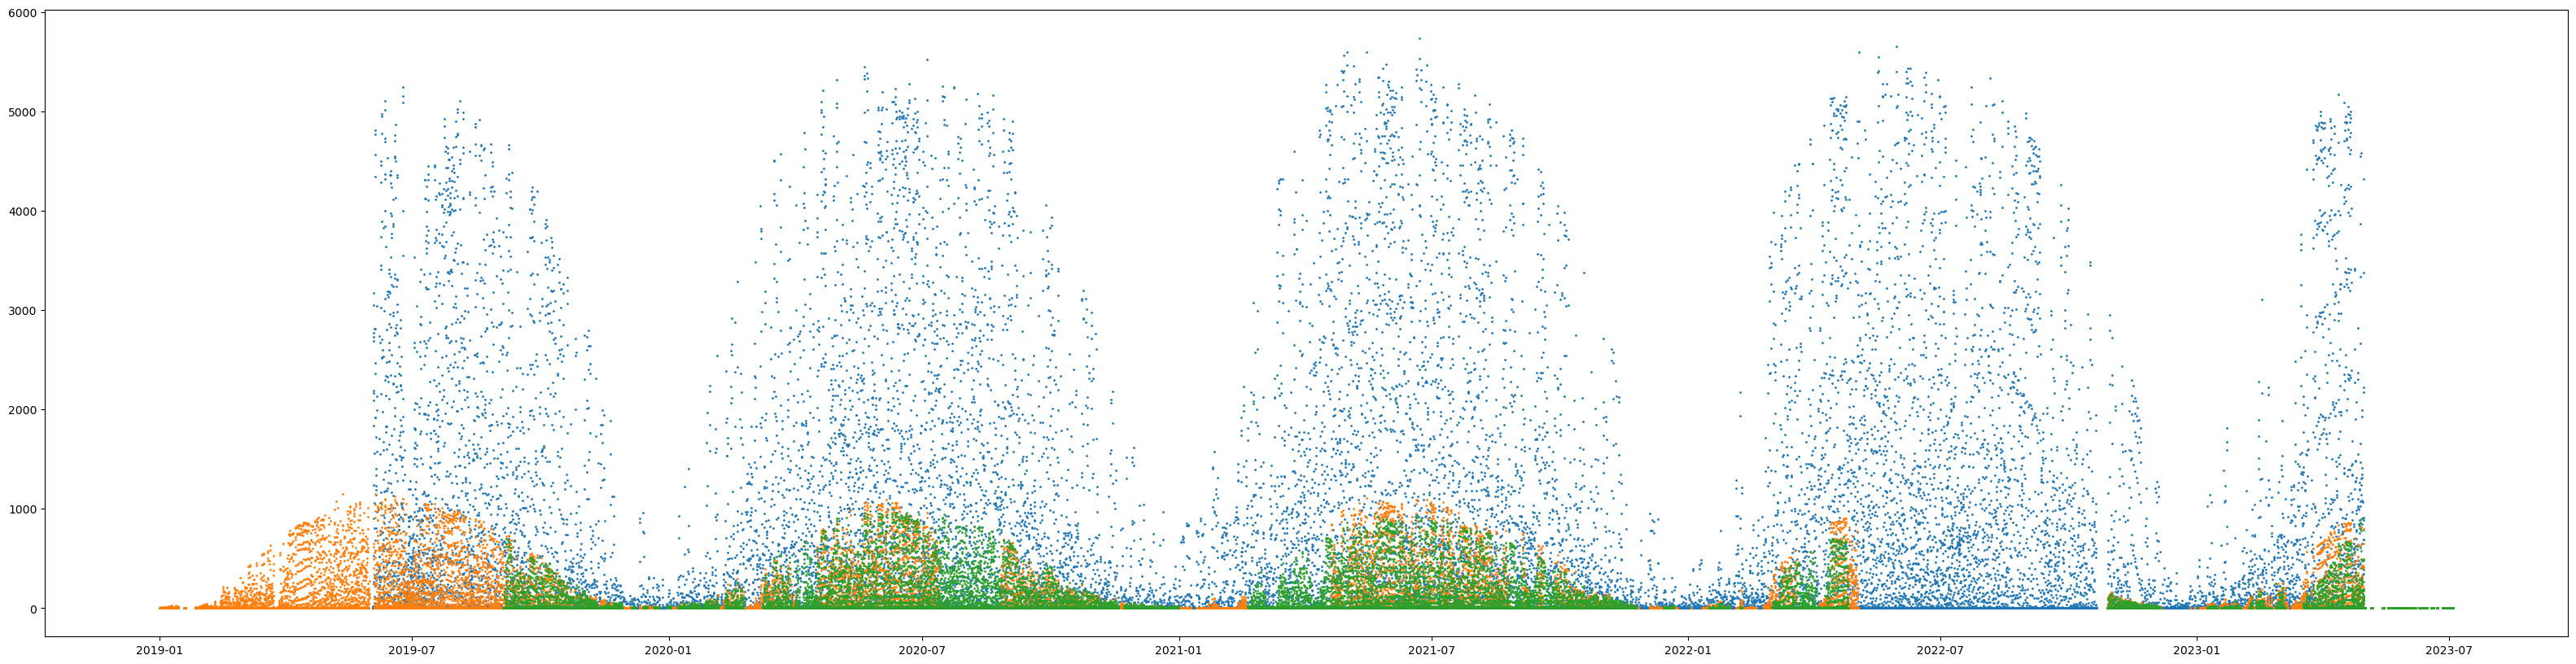

In [33]:
plt.figure(figsize=(40, 10))

for location in locations:
    plt.scatter(y[y.location == location].time, y[y.location == location]["pv_measurement"], s=1)


### Combine X and y

In [34]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data = pd.merge(
    X, y, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

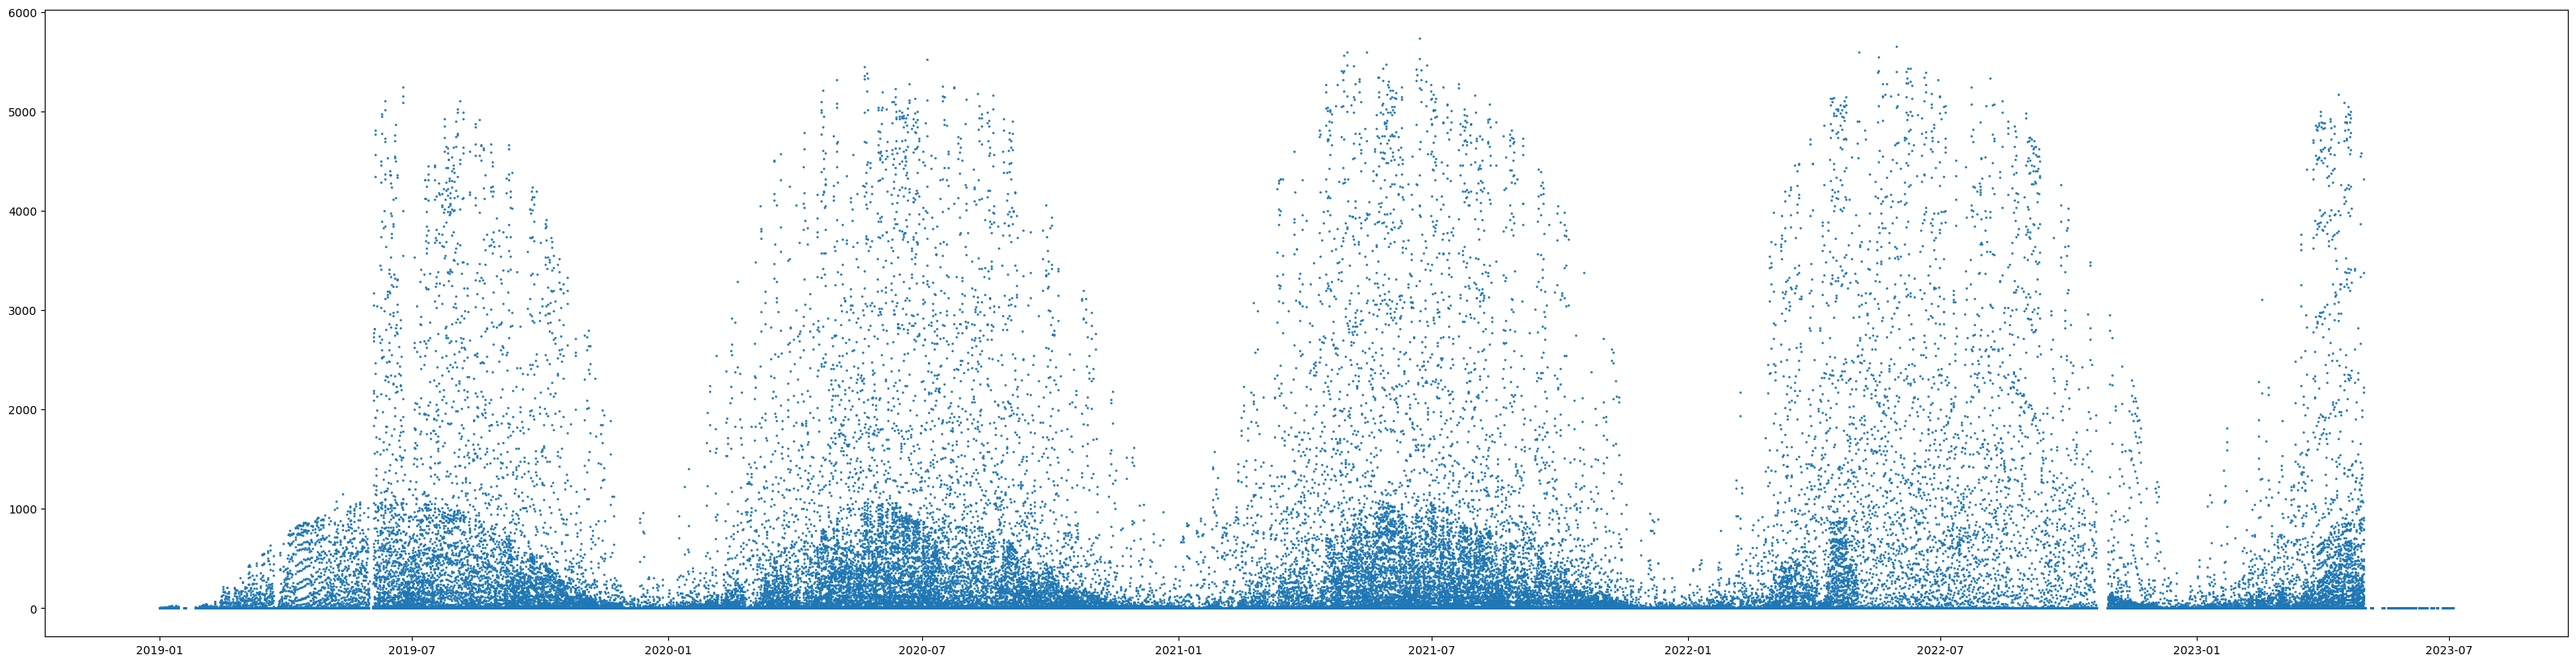

In [35]:
plt.figure(figsize=(40, 10))
plt.scatter(data.date_forecast, data["pv_measurement"], s=1)

### Feature Engineering

#### Add sinus and cosinus features

In [36]:
# Function that sinus and cosinus transform a column

def add_sin_cos(df, column_name, period):
    """
    Add sinus and cosinus transformed columns for the given column.

    Parameters:
    - df: DataFrame to add the transformed columns to.
    - column_name: Name of the column to transform.
    - period: Period of the sinus and cosinus functions.
    """
    df[f"{column_name}_sin"] = np.sin(2 * np.pi * df[column_name] / period)
    df[f"{column_name}_cos"] = np.cos(2 * np.pi * df[column_name] / period)

# Add sinus and cosinus transformed columns for time

data["hour"] = data["date_forecast"].dt.hour
data["month"] = data["date_forecast"].dt.month

add_sin_cos(data, "hour", 23)
add_sin_cos(data, "month", 12)

#### Transform sun_azimuth feature

In [37]:
# Sun azimuth feature engineering

def convert_from_degree_to_ciruclar(df, feature):
    """
    Converts a feature from degree to circular
    """
    df[feature + "_sin"] = np.sin(np.radians(df[feature]))
    df[feature + "_cos"] = np.cos(np.radians(df[feature]))

    return df

# Convert sun_azimuth from degree to circular
data = convert_from_degree_to_ciruclar(data, "sun_azimuth:d")

### Result

In [38]:
data.describe().T.drop(columns=["std", "25%", "50%", "75%"])

,count,mean,min,max
date_forecast,85205,2021-03-27 13:59:56.155155200,2019-01-01 00:00:00,2023-07-03 23:00:00
absolute_humidity_2m:gm3,85205.0,6.215205,0.7,17.5
air_density_2m:kgm3,85205.0,1.25291,1.139,1.427
ceiling_height_agl:m,69963.0,2912.599854,27.799999,12431.299805
clear_sky_energy_1h:J,85205.0,553682.5,0.0,3006697.25
clear_sky_rad:W,85205.0,153.795822,0.0,835.299988
cloud_base_agl:m,78892.0,1751.843872,27.4,11688.700195
dew_or_rime:idx,85205.0,0.015879,-1.0,1.0
dew_point_2m:K,85205.0,275.824188,250.899994,293.799988
diffuse_rad:W,85205.0,42.017376,0.0,340.100006


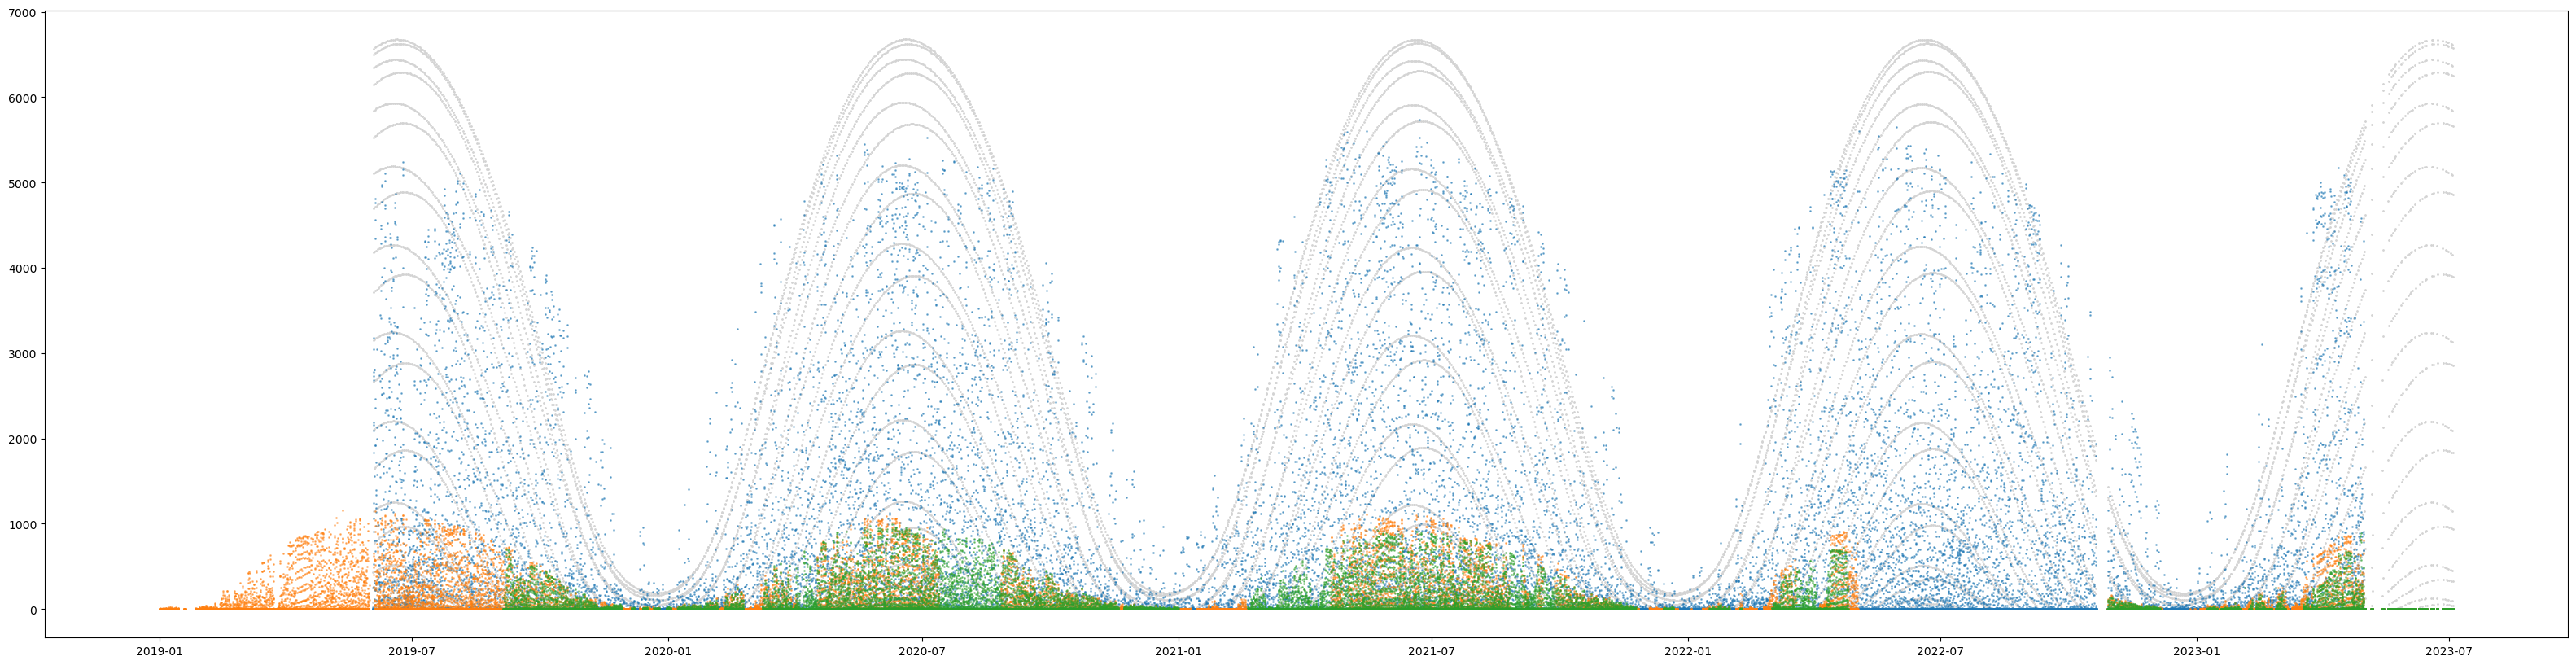

In [39]:
# Plot alignment and values
plt.figure(figsize=(40, 10))

plt.scatter(
    data[data.location == "A"].date_forecast,
    data[data.location == "A"]["clear_sky_rad:W"] * 8,
    s=1,
    color="lightgrey",
)

for loc in locations:
    plt.scatter(
        data[data.location == loc].date_forecast,
        data[data.location == loc]["pv_measurement"],
        s=1,
        alpha=0.5,
    )


In [40]:
# Export to CSV

data.to_csv("../data/processed/data.csv", index=False)